In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import flatten_dict
import pytorch_lightning as pl
from omegaconf import OmegaConf
import torch
from dabs.src.systems import viewmaker, viewmaker_original
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as image
import torchvision
from IPython import display
from viewmaker.src.systems.image_systems.utils import heatmap_of_view_effect
from torchvision.utils import make_grid
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns
%matplotlib inline

In [2]:
import torchvision.transforms.functional as F

def show(imgs,**fig_kwr):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False,**fig_kwr)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [3]:
config = OmegaConf.load('/workspace/dabs/conf/traffic.yaml')
config.debug = True
config.dataset = OmegaConf.load('/workspace/dabs/conf/dataset/traffic_sign_small.yaml')
config.model = OmegaConf.load('/workspace/dabs/conf/model/traffic_model.yaml')

config.dataset.batch_size = 64

pl.seed_everything(config.trainer.seed)

system = viewmaker_original.TrafficViewMaker(config)
system.setup('')
system.load_state_dict(torch.load('/workspace/dabs/exp/models/traffic_gan/presentation.ckpt')['state_dict'],strict=False)

system.eval()

Global seed set to 0


31367 train examples, 7842 val examples


TrafficViewMaker(
  (model): TrafficModel(
    (embed_modules): ModuleList()
    (traffic_model): Net(
      (conv1): Conv2d(3, 100, kernel_size=(5, 5), stride=(1, 1))
      (bn1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1))
      (bn2): BatchNorm2d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(150, 250, kernel_size=(3, 3), stride=(1, 1))
      (bn3): BatchNorm2d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_drop): Dropout2d(p=0.5, inplace=False)
      (fc1): Linear(in_features=1000, out_features=350, bias=True)
      (fc2): Linear(in_features=350, out_features=43, bias=True)
      (localization): Sequential(
        (0): Conv2d(3, 8, kernel_size=(7, 7), stride=(1, 1))
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (2): ReLU(inplace=True)
        (3): Conv2

## benchmark on test dataset

In [4]:
adv_dir = "/workspace/dabs/data/natural_images/traffic_sign/GTSRB/Validation_Adversarial_v0/Images/"

import os
from glob import glob
import cv2
from PIL import Image
from torchvision import transforms

from pathlib import Path
result = list(Path(adv_dir).rglob("*.ppm"))


transform = transforms.Compose(
            [transforms.Resize((32, 32)),
             transforms.CenterCrop((32, 32)),
             transforms.ToTensor()]
        )

data = []
labels = []
for img in result:
    try:
        image = Image.open(img).convert(mode='RGB')
        image = transform(image)
        data.append(image)
        labels.append(int(str(img).replace(adv_dir,'')[:5]))
    except:
        print("Error in " + img)

labels = torch.from_numpy(np.array(labels))
X_test = torch.stack(data)

pred=system.predict(X_test).squeeze()

#Accuracy with the test data
print('Test Data accuracy: ',((pred==labels).sum()/len(labels))*100)

TypeError: can only concatenate str (not "PosixPath") to str

## test on augmentations of test

In [ ]:
pl.seed_everything(123)

no_transform = transforms.Compose(
            [transforms.Resize((32, 32)),
             transforms.CenterCrop((32, 32)),
             transforms.ToTensor()]
        )

# Resize, normalize and jitter image brightness
data_jitter_brightness = transforms.Compose([
	transforms.Resize((32, 32)),
    # transforms.ColorJitter(brightness=-5),
    transforms.ColorJitter(brightness=5),
    transforms.ToTensor(),
])

# Resize, normalize and jitter image saturation
data_jitter_saturation = transforms.Compose([
	transforms.Resize((32, 32)),
    transforms.ColorJitter(saturation=5),
    # transforms.ColorJitter(saturation=-5),
    transforms.ToTensor(),
])

# Resize, normalize and jitter image contrast
data_jitter_contrast = transforms.Compose([
	transforms.Resize((32, 32)),
    transforms.ColorJitter(contrast=5),
    # transforms.ColorJitter(contrast=-5),
    transforms.ToTensor(),
])

# Resize, normalize and jitter image hues
data_jitter_hue = transforms.Compose([
	transforms.Resize((32, 32)),
    transforms.ColorJitter(hue=0.4),
    transforms.ToTensor(),
])

# Resize, normalize and rotate image
data_rotate = transforms.Compose([
	transforms.Resize((32, 32)),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
])

# Resize, normalize and flip image horizontally and vertically
data_hvflip = transforms.Compose([
	transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(1),
    transforms.RandomVerticalFlip(1),
    transforms.ToTensor(),
])

# Resize, normalize and flip image horizontally
data_hflip = transforms.Compose([
	transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(1),
    transforms.ToTensor(),
])

# Resize, normalize and flip image vertically
data_vflip = transforms.Compose([
	transforms.Resize((32, 32)),
    transforms.RandomVerticalFlip(1),
    transforms.ToTensor(),
])

# Resize, normalize and shear image
data_shear = transforms.Compose([
	transforms.Resize((32, 32)),
    transforms.RandomAffine(degrees = 15,shear=2),
    transforms.ToTensor(),
])

# Resize, normalize and translate image
data_translate = transforms.Compose([
	transforms.Resize((32, 32)),
    transforms.RandomAffine(degrees = 15,translate=(0.1,0.1)),
    transforms.ToTensor(),
])

# Resize, normalize and crop image 
data_center = transforms.Compose([
	transforms.Resize((36, 36)),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
])

# Resize, normalize and convert image to grayscale
data_grayscale = transforms.Compose([
	transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

# Resize, normalize and convert image to grayscale
sharpness = transforms.Compose([
	transforms.Resize((32, 32)),
    transforms.RandomAdjustSharpness(sharpness_factor=2,p=1),
    transforms.ToTensor(),
])

transform_candidates = [no_transform,data_jitter_saturation,data_jitter_contrast,data_jitter_hue,data_rotate,data_hvflip,data_hflip,data_vflip,data_shear,data_translate,data_center,data_grayscale,sharpness]

# for transform in transform_candidates:

# data = []
labels = []
for img in tqdm(result):
    try:
        label = int(str(img).replace(adv_dir,'')[:5])
        image = Image.open(img).convert(mode='RGB')
        x = torch.stack([ transform(image) for transform in transform_candidates])
        pred=system.predict(x).squeeze()
        labels.append(torch.hstack([torch.Tensor([label]),pred]).numpy())
    except:
        print("Error in " + img)

results_df = pd.DataFrame(data=np.array(labels),columns=['original','no_transform','data_jitter_saturation','data_jitter_contrast','data_jitter_hue','data_rotate','data_hvflip','data_hflip','data_vflip','data_shear','data_translate','data_center','data_grayscale','sharpness'])


Global seed set to 123


  0%|          | 0/7808 [00:00<?, ?it/s]

In [ ]:
columns=['original','no_transform','data_jitter_saturation','data_jitter_contrast','data_jitter_hue','data_rotate','data_hvflip','data_hflip','data_vflip','data_shear','data_translate','data_center','data_grayscale','sharpness']

d = {}
for col in columns[1:]:
    d[f'original_vs_{col}'] = [(results_df['original'] == results_df[col]).mean()]

for col in columns[2:]:
    d[f'no_transform_vs_{col}'] = [(results_df['no_transform'] == results_df[col]).mean()]



In [ ]:
pd.DataFrame.from_dict(d).T

,0
original_vs_no_transform,0.300077
original_vs_data_jitter_saturation,0.318648
original_vs_data_jitter_contrast,0.311475
original_vs_data_jitter_hue,0.284708
original_vs_data_rotate,0.301486
original_vs_data_hvflip,0.299821
original_vs_data_hflip,0.269211
original_vs_data_vflip,0.251793
original_vs_data_shear,0.301358
original_vs_data_translate,0.309298


# again

In [5]:
from __future__ import print_function
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import PIL.Image as Image
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.datasets as datasets
import numpy as np
from gtsrb_pytorch.model import Net
import pandas as pd
from torchvision import datasets, transforms
from gtsrb_pytorch.data import *
import seaborn as sns


state_dict = torch.load('/workspace/gtsrb_pytorch/model/model_40.pth')
model = Net()
model.load_state_dict(state_dict)
model.eval()


if torch.cuda.is_available():
    use_gpu = True
    print("Using GPU")
else:
	use_gpu = False
	print("Using CPU")

if use_gpu:
    model.cuda()

model.eval()

Using GPU


Net(
  (conv1): Conv2d(3, 100, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(150, 250, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1000, out_features=350, bias=True)
  (fc2): Linear(in_features=350, out_features=43, bias=True)
  (localization): Sequential(
    (0): Conv2d(3, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True

In [14]:

# val_data_path = '/workspace/dabs/data/adv_data/traffic_sign/07_01_2023/traffic_budget_budget=0.005/val'
val_data_path = '/workspace/dabs/data/adv_data/traffic_sign/FGSM/val'
# val_data_path = '/workspace/gtsrb_pytorch/data/val_images'
# Apply data transformations on the training images to augment dataset

   


In [10]:
def validate(model,val_loader):
    correct = 0
    for data, target in tqdm(val_loader):
        with torch.no_grad():
            data, target = Variable(data), Variable(target)
            if use_gpu:
                data = data.cuda()
                target = target.cuda()
            output = model.forward_original(data)
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    acc = correct / len(val_loader.dataset)
    return acc


In [15]:
traffic_transforms = {'data_transforms': data_transforms,'data_jitter_brightness': data_jitter_brightness,'data_jitter_saturation': data_jitter_saturation,'data_jitter_contrast': data_jitter_contrast,
'data_jitter_hue': data_jitter_hue,'data_rotate': data_rotate,'data_hvflip': data_hvflip,'data_hflip': data_hflip,'data_vflip': data_vflip,'data_shear': data_shear,'data_translate': data_translate,
'data_center': data_center,'data_grayscale': data_grayscale}

results = dict()
for k in traffic_transforms.keys():
    t = traffic_transforms[k]
    val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(val_data_path,transform=t,is_valid_file=lambda s: 'view' in s),
    batch_size=32, shuffle=False, num_workers=4, pin_memory=use_gpu)
    acc = validate(model,val_loader)
    results[k] = acc
    print(f'{k}: acc {acc*100.0:0.2f}%')


100%|██████████| 244/244 [00:01<00:00, 132.48it/s]


data_transforms: acc 6.17%


100%|██████████| 244/244 [00:02<00:00, 111.01it/s]


data_jitter_brightness: acc 5.33%


100%|██████████| 244/244 [00:02<00:00, 109.61it/s]


data_jitter_saturation: acc 6.16%


100%|██████████| 244/244 [00:02<00:00, 96.31it/s] 


data_jitter_contrast: acc 5.93%


100%|██████████| 244/244 [00:02<00:00, 94.11it/s] 


data_jitter_hue: acc 6.17%


100%|██████████| 244/244 [00:02<00:00, 116.42it/s]


data_rotate: acc 6.11%


100%|██████████| 244/244 [00:02<00:00, 121.91it/s]


data_hvflip: acc 6.13%


100%|██████████| 244/244 [00:01<00:00, 122.08it/s]


data_hflip: acc 5.46%


100%|██████████| 244/244 [00:01<00:00, 123.17it/s]


data_vflip: acc 5.83%


100%|██████████| 244/244 [00:02<00:00, 115.29it/s]


data_shear: acc 6.10%


100%|██████████| 244/244 [00:02<00:00, 114.97it/s]


data_translate: acc 6.07%


100%|██████████| 244/244 [00:01<00:00, 122.03it/s]


data_center: acc 6.19%


100%|██████████| 244/244 [00:02<00:00, 118.12it/s]

data_grayscale: acc 6.12%


<AxesSubplot:>

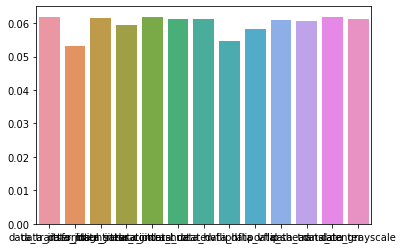

In [16]:
pd_result = pd.DataFrame.from_dict({k: [results[k].item()] for k in results.keys()})
sns.barplot(pd_result)

In [17]:
raw_data_key = 'data_transforms'
raw_adversarial = results[raw_data_key].item()
w_transform = np.mean([results[k].item() for k in results.keys() if k!=raw_data_key])
print(f'raw_adv ASR = {(1-raw_adversarial)*100.}% ; mean additional transform ASR = {(1-w_transform)*100.}%')

raw_adv ASR = 93.82684417068958% ; mean additional transform ASR = 94.03389689202109%
